In [186]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import random
import sklearn
from matplotlib import pyplot as plt
import tensorflow
import keras

In [187]:
fb_df = pd.read_csv("nebraska_boxscores_1962-2022.csv")
fb_df = pd.get_dummies(fb_df, columns = ['site'])
fb_df = fb_df.loc[fb_df['season'] >= 2000]
fb_df.rename(columns= {"site_away":"away", "site_home":"home", "site_neutral-away":"neutral-away", "site_neutral-home":"neutral-home"}, inplace = True)
fb_df.drop(columns = ['date','time','opp', "ne_pen_num", "ne_pen_yards"], inplace = True)
#changing "opp_rank" and "ne_rank" to just classify if the team is ranked (top 25 in the nation)
fb_df["opp_rank"] = fb_df["opp_rank"] <= 25.0
fb_df["ne_rank"] = fb_df["ne_rank"] <= 25.0
fb_df.head()

,season,conference,opp_rank,ne_rank,opp_score,ne_score,opp_rush_att,opp_rush_yards,ne_rush_att,ne_rush_yards,...,ne_fum,spread,temp,humidity,wind_speed,wind_bearing,away,home,neutral-away,neutral-home
456,2000,False,False,True,13,49,29,193,60,505,...,0,-49.5,90.8,0.46,9.2,191,0,1,0,0
457,2000,False,True,True,24,27,40,184,59,274,...,0,-13.5,81.1,0.65,10.3,168,1,0,0,0
458,2000,False,False,True,13,42,31,47,51,331,...,1,-41.5,50.9,0.74,18.4,11,0,1,0,0
459,2000,True,False,True,24,42,31,209,53,311,...,0,-34.0,82.7,0.27,19.7,191,0,1,0,0
460,2000,True,False,True,27,49,25,37,60,336,...,0,-16.0,41.0,0.39,13.8,341,1,0,0,0


For the sake of convenience for predictions I am going to create a new column in this data frame that simply compares the scores to see if Nebraska won or lost.

In [188]:
fb_df['win'] = fb_df["ne_score"] > fb_df['opp_score']

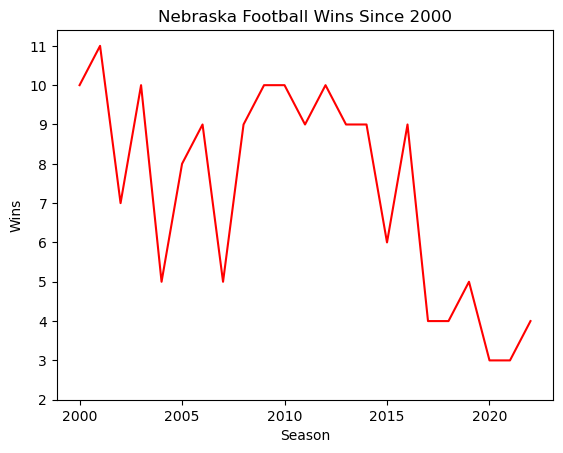

In [189]:
winflow = (fb_df.loc[fb_df['win']==True]).groupby('season').count()['win']
plt.plot(winflow, color= 'red')
plt.xlabel("Season")
plt.ylabel("Wins")
plt.yticks(np.arange(2,12))
plt.title("Nebraska Football Wins Since 2000")
plt.show()

In [190]:
fb_df = fb_df.dropna()
test_df = fb_df.sample(frac= 0.3, random_state= 101)
train_df = fb_df.drop(test_df.index)
xtrain = train_df.drop(columns = ['away', 'win', "ne_score", 'opp_score', 'season'])
xtest = test_df.drop(columns = ['away', 'win', "ne_score", 'opp_score', 'season'])
ytrain = train_df['win']
ytest = test_df['win']

In [191]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(xtrain)
train_stan = pd.DataFrame(scaler.transform(xtrain), columns = xtrain.columns)
test_stan = pd.DataFrame(scaler.transform(xtest), columns = xtest.columns)
train_stan.head()

,conference,opp_rank,ne_rank,opp_rush_att,opp_rush_yards,ne_rush_att,ne_rush_yards,opp_pass_comp,opp_pass_att,opp_pass_yards,...,ne_int,ne_fum,spread,temp,humidity,wind_speed,wind_bearing,home,neutral-away,neutral-home
0,-1.377338,-0.622354,0.994937,-0.815506,0.464713,1.546638,2.919824,-0.504707,0.443018,-0.629594,...,1.998885,-0.874316,-2.772495,1.830767,-0.523872,0.536628,0.094336,0.955312,-0.218797,-0.191943
1,-1.377338,-0.622354,0.994937,-0.612531,-1.162320,0.761135,1.257547,0.218927,0.734582,0.479217,...,-0.918007,0.056712,-2.243249,-0.592998,0.939256,2.620143,-1.690703,0.955312,-0.218797,-0.191943
2,0.726038,-0.622354,0.994937,-0.612531,0.643018,0.935692,1.066480,0.218927,0.637394,0.826420,...,-0.918007,-0.874316,-1.747081,1.338724,-1.516709,2.914553,0.094336,0.955312,-0.218797,-0.191943
3,0.726038,-0.622354,0.994937,-2.540793,-1.474354,3.030365,2.317965,0.653107,1.512084,-0.315991,...,0.054291,0.056712,-0.820902,1.065367,-0.523872,1.601033,-0.113918,-1.046778,-0.218797,-0.191943
4,0.726038,-0.622354,0.994937,-1.018481,-1.630371,2.157584,2.480371,-1.517794,-0.334484,-1.458402,...,-0.918007,-0.874316,-2.673261,0.555101,0.416710,1.351917,-0.113918,0.955312,-0.218797,-0.191943


In [192]:
from sklearn import metrics
from sklearn import linear_model
Cs = np.arange(0.00001, 2, 0.001)
coefs_lasso = pd.DataFrame()
auc_list = []
fb_df.dropna()
for threshold in Cs:
    model = sklearn.linear_model.LogisticRegression(penalty='l1', solver = 'liblinear', C=threshold)
    tempmodel = model.fit(train_stan, ytrain)
    coefs_lasso = pd.concat([coefs_lasso, pd.Series(tempmodel.coef_[0]).to_frame().T], ignore_index=True)
    pred = tempmodel.predict(test_stan)
    fpr, tpr, thresholds = metrics.roc_curve(ytest, pred, pos_label=1)
    auc_list.append(metrics.auc(fpr, tpr))
lassoframe = coefs_lasso
for i in lassoframe.columns:
    lassoframe.rename(columns= {i : train_stan.columns[i]}, inplace = True)
lassoframe['Threshold'] = Cs
lassoframe['auc'] = auc_list
lassoframe.tail()

,conference,opp_rank,ne_rank,opp_rush_att,opp_rush_yards,ne_rush_att,ne_rush_yards,opp_pass_comp,opp_pass_att,opp_pass_yards,...,spread,temp,humidity,wind_speed,wind_bearing,home,neutral-away,neutral-home,Threshold,auc
1995,0.167543,-0.278463,0.0,0.081562,-1.979875,0.0,0.863127,-2.738803,3.278873,-1.679246,...,-1.352777,-0.273162,0.0,-0.612105,0.433032,-0.077548,0.000406,-0.090696,1.99501,0.905983
1996,0.167925,-0.278544,0.0,0.081701,-1.979794,0.0,0.863705,-2.738241,3.278653,-1.679808,...,-1.352634,-0.273133,0.0,-0.612338,0.433432,-0.077558,0.000764,-0.090521,1.99601,0.905983
1997,0.168092,-0.278472,0.0,0.082732,-1.980955,0.0,0.863885,-2.737090,3.279437,-1.681644,...,-1.352814,-0.273126,0.0,-0.612619,0.433560,-0.077412,0.000817,-0.090558,1.99701,0.905983
1998,0.167487,-0.278915,0.0,0.083603,-1.983129,0.0,0.865189,-2.747076,3.290093,-1.683749,...,-1.353271,-0.273621,0.0,-0.612525,0.434182,-0.078531,0.000050,-0.091094,1.99801,0.905983
1999,0.167685,-0.278924,0.0,0.084026,-1.983459,0.0,0.865441,-2.746814,3.289877,-1.683753,...,-1.353591,-0.273667,0.0,-0.612657,0.434256,-0.078548,0.000145,-0.091065,1.99901,0.905983


In [193]:
lassoframe.loc[lassoframe['auc'] == max(auc_list)]

,conference,opp_rank,ne_rank,opp_rush_att,opp_rush_yards,ne_rush_att,ne_rush_yards,opp_pass_comp,opp_pass_att,opp_pass_yards,...,spread,temp,humidity,wind_speed,wind_bearing,home,neutral-away,neutral-home,Threshold,auc
682,0.027329,-0.203843,0.0,0.000000,-1.421541,0.0,0.489973,-1.292600,1.536049,-0.894319,...,-1.106260,-0.152987,0.0,-0.383828,0.108047,0.000000,0.0,0.000000,0.68201,0.907692
684,0.027771,-0.204046,0.0,0.000000,-1.422746,0.0,0.490659,-1.295702,1.539590,-0.895732,...,-1.106760,-0.153251,0.0,-0.384469,0.108839,0.000000,0.0,0.000000,0.68401,0.907692
685,0.028089,-0.203882,0.0,0.000000,-1.423006,0.0,0.491049,-1.294493,1.538572,-0.896043,...,-1.107611,-0.153474,0.0,-0.385035,0.109223,0.000000,0.0,0.000000,0.68501,0.907692
686,0.028238,-0.203957,0.0,0.000000,-1.423745,0.0,0.491444,-1.296522,1.540508,-0.896918,...,-1.107789,-0.153619,0.0,-0.385279,0.109640,0.000000,0.0,0.000000,0.68601,0.907692
687,0.028507,-0.204007,0.0,0.000000,-1.424167,0.0,0.491840,-1.296741,1.542425,-0.898823,...,-1.107920,-0.153738,0.0,-0.385797,0.110183,0.000000,0.0,0.000000,0.68701,0.907692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804,0.151953,-0.271364,0.0,0.013380,-1.879740,0.0,0.794023,-2.589230,3.067264,-1.568463,...,-1.310249,-0.256064,0.0,-0.588139,0.398943,-0.053601,0.0,-0.079288,1.80401,0.907692
1805,0.152129,-0.271444,0.0,0.012158,-1.878803,0.0,0.792968,-2.588388,3.064081,-1.566089,...,-1.310831,-0.256028,0.0,-0.588058,0.398693,-0.053588,0.0,-0.079332,1.80501,0.907692
1806,0.152160,-0.271504,0.0,0.013744,-1.880204,0.0,0.794123,-2.589336,3.068500,-1.569387,...,-1.310718,-0.256282,0.0,-0.588522,0.399397,-0.053786,0.0,-0.079411,1.80601,0.907692
1807,0.152260,-0.272004,0.0,0.014690,-1.882262,0.0,0.795291,-2.597799,3.077589,-1.571727,...,-1.311127,-0.256415,0.0,-0.588439,0.399879,-0.054496,0.0,-0.079607,1.80701,0.907692


In [194]:
threshold = lassoframe.loc[lassoframe['auc'] == max(auc_list)]['Threshold'][685]
threshold

0.68501

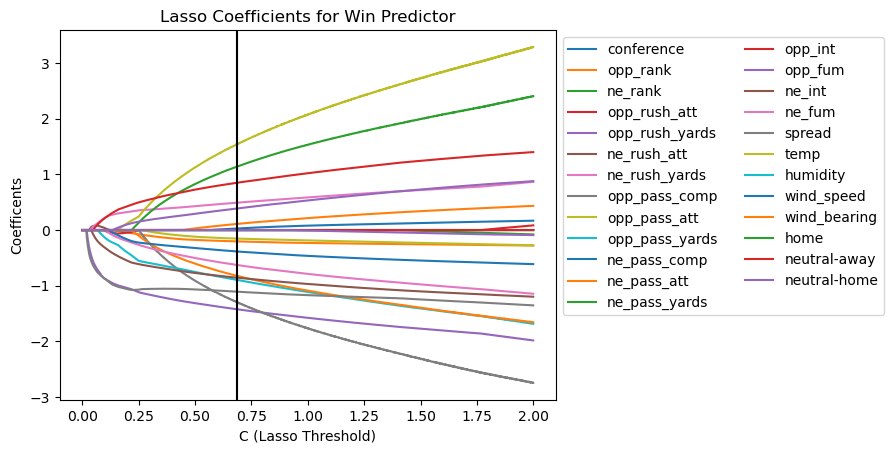

In [195]:
for column in xtrain.columns:
    plt.plot(lassoframe['Threshold'], lassoframe[column], label = column)
plt.legend()
plt.axvline(x = threshold, color = 'black')
plt.legend(bbox_to_anchor =(1, 1), ncol = 2)
plt.title("Lasso Coefficients for Win Predictor")
plt.xlabel('C (Lasso Threshold)')
plt.ylabel('Coefficents')
plt.show()

In [141]:
neX = fb_df[['ne_rush_att', 'ne_rush_yards', 'ne_pass_comp', 'ne_pass_yards', 'ne_int', 'ne_fum']]
neX = sm.add_constant(neX)
nefit = sm.Logit(fb_df['win'],neX).fit()
nefit.summary()

Optimization terminated successfully.
         Current function value: 0.473227
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                  281
Model:                          Logit   Df Residuals:                      274
Method:                           MLE   Df Model:                            6
Date:                Mon, 08 May 2023   Pseudo R-squ.:                  0.3066
Time:                        15:53:02   Log-Likelihood:                -132.98
converged:                       True   LL-Null:                       -191.77
Covariance Type:            nonrobust   LLR p-value:                 5.222e-23
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.5847      1.080     -3.319      0.001      -5.702      -1.468
ne_rush_att       0.0692      0.024      2.876      0.004       0.022       0.116
ne_rush_yards     0.0078      0.003      3.066      0.002       0.003       0.013
ne_pass_comp     -0.0804      0.042     -1.898      0.058      -0.163       0.003
ne_pass_yards     0.0093      0.003      2.874      0.004       0.003       0.016
ne_int           -0.7756      0.169     -4.601      0.000      -1.106      -0.445
ne_fum           -0.3522      0.153     -2.302      0.021      -0.652      -0.052
=================================================================================
"""

In [142]:
oppX = fb_df[['opp_rush_att', 'opp_rush_yards', 'opp_pass_comp', 'opp_pass_yards', 'opp_int', 'opp_fum']]
oppX = sm.add_constant(oppX)
oppfit = sm.Logit(fb_df['win'],oppX).fit()
oppfit.summary()

Optimization terminated successfully.
         Current function value: 0.400647
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                  281
Model:                          Logit   Df Residuals:                      274
Method:                           MLE   Df Model:                            6
Date:                Mon, 08 May 2023   Pseudo R-squ.:                  0.4129
Time:                        15:53:03   Log-Likelihood:                -112.58
converged:                       True   LL-Null:                       -191.77
Covariance Type:            nonrobust   LLR p-value:                 1.304e-31
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.9067      1.190      5.804      0.000       4.574       9.239
opp_rush_att      -0.0994      0.028     -3.573      0.000      -0.154      -0.045
opp_rush_yards    -0.0097      0.003     -3.436      0.001      -0.015      -0.004
opp_pass_comp     -0.0416      0.039     -1.068      0.286      -0.118       0.035
opp_pass_yards    -0.0091      0.003     -2.977      0.003      -0.015      -0.003
opp_int            1.0940      0.214      5.106      0.000       0.674       1.514
opp_fum            0.6760      0.236      2.865      0.004       0.214       1.138
==================================================================================
"""

In [143]:
netable = nefit.pred_table()
netable

array([[ 81.,  39.],
       [ 29., 132.]])

In [144]:
opptable = oppfit.pred_table()
opptable

array([[ 95.,  25.],
       [ 26., 135.]])

In [145]:
(netable[0][0] + netable[1][1]) / len(fb_df)

0.7580071174377224

In [146]:
(opptable[0][0] + opptable[1][1]) / len(fb_df)

0.8185053380782918

In [147]:
oppX.drop(columns = "const", inplace = True)

In [148]:
scaler = StandardScaler()
scaler.fit(oppX)
opp_stan = pd.DataFrame(scaler.transform(oppX), columns = oppX.columns)
opp_stan.head()

,opp_rush_att,opp_rush_yards,opp_pass_comp,opp_pass_yards,opp_int,opp_fum
0,-0.798559,0.424870,-0.496797,-0.646685,-0.068888,-0.695617
1,0.330086,0.330184,-1.976180,-1.876057,-0.068888,-0.695617
2,-0.593351,-1.111146,0.175650,0.430375,0.737672,-0.695617
3,-0.593351,0.593200,0.175650,0.767636,-0.068888,0.549405
4,-1.208975,-1.216352,0.579118,1.453038,8.803265,-0.695617


In [202]:
C1s = np.arange(0.00001, 0.25, 0.001)
coefs_lasso1 = pd.DataFrame()
for threshold in C1s:
    model = sklearn.linear_model.LogisticRegression(penalty='l1', solver = 'liblinear', C=threshold)
    tempmodel = model.fit(opp_stan, fb_df['win'])
    coefs_lasso1 = pd.concat([coefs_lasso1, pd.Series(tempmodel.coef_[0]).to_frame().T], ignore_index=True)
lassoframe1 = coefs_lasso1
for i in lassoframe1.columns:
    lassoframe1.rename(columns= {i : opp_stan.columns[i]}, inplace = True)
lassoframe1['Threshold'] = C1s
lassoframe1

,opp_rush_att,opp_rush_yards,opp_pass_comp,opp_pass_yards,opp_int,opp_fum,Threshold
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00001
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00101
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00201
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00301
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00401
...,...,...,...,...,...,...,...
245,-0.698660,-0.770973,-0.117276,-0.702063,0.976146,0.353710,0.24501
246,-0.699569,-0.771397,-0.118009,-0.702441,0.977300,0.354318,0.24601
247,-0.700377,-0.771885,-0.118683,-0.702696,0.978488,0.354921,0.24701
248,-0.701155,-0.772359,-0.119221,-0.703255,0.979617,0.355527,0.24801


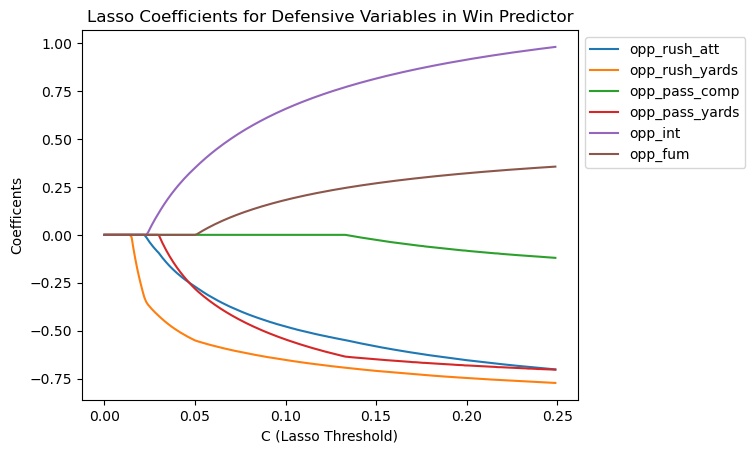

In [203]:
for column in oppX.columns:
    plt.plot(lassoframe1['Threshold'], lassoframe1[column], label = column)
plt.legend()
plt.legend(bbox_to_anchor =(1, 1), ncol = 1)
plt.title("Lasso Coefficients for Defensive Variables in Win Predictor")
plt.xlabel('C (Lasso Threshold)')
plt.ylabel('Coefficents')
plt.show()